In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import time
from numba import jit

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

alpha = np.sqrt(2/3)
beta = 6.1548146
xi = -0.3009
V0 = 4.7*10**-9

@jit(nopython=True)
def V(phi):
    retval = V0*(1 + xi - np.exp(-alpha*np.tanh(phi/np.sqrt(6))) - xi*np.exp(-beta*np.tanh(phi/np.sqrt(6))**2))**2
    return retval

@jit(nopython=True)
def dV(phi): 
    retval = 2*V0*(1 + xi - np.exp(-alpha*np.tanh(phi/np.sqrt(6))) - xi*np.exp(-beta*np.tanh(phi/np.sqrt(6))**2)) \
    *( (alpha*np.exp(-alpha*np.tanh(phi/np.sqrt(6)))*np.cosh(phi/np.sqrt(6))**-2)/np.sqrt(6) + np.sqrt(2/3)*beta*xi \
      *np.exp(-beta*np.tanh(phi/np.sqrt(6))**2)*np.tanh(phi/np.sqrt(6))*np.cosh(phi/np.sqrt(6))**-2) 
    return retval

@jit(nopython=True)
def ddV(x):
    a1 = alpha*(np.exp( -alpha*np.tanh(x/np.sqrt(6)) )*np.cosh(x/np.sqrt(6))**-2)/np.sqrt(6) + np.sqrt(2/3)*beta*xi*np.exp( -beta*np.tanh(x/np.sqrt(6))**2 ) \
    *np.cosh(x/np.sqrt(6))**-2 *np.tanh(x/np.sqrt(6))
    
    a2 = 1 - np.exp( -alpha*np.tanh(x/np.sqrt(6)) ) + xi - xi*np.exp( -beta*np.tanh(x/np.sqrt(6))**2 )
    
    a3 = -(alpha/np.sqrt(6))**2 *np.exp( -alpha*np.tanh(x/np.sqrt(6)) )*np.cosh(np.sqrt(6))**-4 \
    + (beta*xi/3)*np.exp( -beta*np.tanh(x/np.sqrt(6))**2 )*np.cosh(x/np.sqrt(6))**-4 \
    + (alpha/3)*np.exp( -alpha*np.tanh(x/np.sqrt(6)) )*np.cosh(x/np.sqrt(6))**-2 *np.tanh(x/np.sqrt(6)) \
    + (2*beta*xi/3)*np.exp( -beta*np.tanh(x/np.sqrt(6))**2 )*np.cosh(x/np.sqrt(6))**-2 *np.tanh(x/np.sqrt(6))**2 \
    + (2*beta*beta*xi/3)*np.exp( -beta*np.tanh(x/np.sqrt(6))**2 )*np.cosh(x/np.sqrt(6))**-4 *np.tanh(x/np.sqrt(6))**2
    
    return 2*V0*a1**2 + 2*V0*a2*a3

dN = 0.001

'''
Jitted function that solves the background inflaton evolution using an initial condition
The inflaton equations are solved using the RK4 method
'''
@jit(nopython=True)
def field_return(phi_in, efolds):
    N_test = efolds
    n = round(N_test/dN)
    phi = np.zeros(n)
    dphi = np.zeros(n)
    
    
    phi[0] = phi_in
    dphi[0] = -dV(phi_in)/V(phi_in)
    
    for i in range(n-1):
        k0 = dN*dphi[i]
        l0 = -dN*(3*dphi[i]-0.5*dphi[i]**3)-dN*(3-0.5*dphi[i]**2)*dV(phi[i])/V(phi[i])
        
        k1 = dN*(dphi[i]+0.5*l0)
        l1 = -dN*(3*(dphi[i]+0.5*l0)-0.5*(dphi[i]+0.5*l0)**3)-dN*(3-0.5*(dphi[i]+0.5*l0)**2)*dV(phi[i]+0.5*k0)/V(phi[i]+0.5*k0)
        
        k2 = dN*(dphi[i]+0.5*l1)
        l2 = -dN*(3*(dphi[i]+0.5*l1)-0.5*(dphi[i]+0.5*l1)**3)-dN*(3-0.5*(dphi[i]+0.5*l1)**2)*dV(phi[i]+0.5*k1)/V(phi[i]+0.5*k1)
        
        k3 = dN*(dphi[i]+l2)
        l3 = -dN*(3*(dphi[i]+l2)-0.5*(dphi[i]+l2)**3)-dN*(3-0.5*(dphi[i]+l2)**2)*dV(phi[i]+k2)/V(phi[i]+k2)
        
        phi[i+1] = phi[i] + (k0 + 2*k1 + 2*k2 + k3)/6
        dphi[i+1] = dphi[i] + (l0 + 2*l1 + 2*l2 + l3)/6
        
    return phi, dphi

In [2]:
N_end = 62
n_pts = round(N_end/dN)
N = np.linspace(0, N_end, n_pts)

[phi, dphi] = field_return(6.35, N_end)

eps1 = 0.5*dphi**2
eps2 = np.gradient(eps1,dN)/eps1
eta  = eps1 - 0.5*eps2
deps1 = np.gradient(eps1,dN)
deta  = np.gradient(eta,dN)
H = np.sqrt(V(phi)/(3-eps1))
a = 0.0186*np.exp(N)

'''
Jitted function that computes the power spectrum of curvature perturbations for specified k-modes
The Mukhanov-Sasaki equation is solved using RK4
'''
@jit(nopython=True)
def mode_evolve(k, N, phi, dphi):
    horizon = a*H
    Initial = 100.0*horizon
    Final = 0.01*horizon
    test_in = np.absolute(Initial-k); test_fin = np.absolute(Final-k)
    Nii = np.where(test_in == np.min(test_in))[0][0]
    Nff = np.where(test_fin == np.min(test_fin))[0][0]
    n_ = Nff - Nii + 1
    
    '''
    Bunch-Davies initial conditions
    '''
    
    uk_sol = np.zeros(n_); Duk_sol = np.zeros(n_)
    vk_sol = np.zeros(n_); Dvk_sol = np.zeros(n_)
    
    uk_sol[0] = 1/np.sqrt(2*k); Duk_sol[0] = 0
    vk_sol[0] = 0; Dvk_sol[0] = -np.sqrt(k)/(0.01*np.sqrt(2)*k)
    
    for i in range(n_-1):
        f1 = -(1-eps1[Nii+i])*Duk_sol[i] - (k**2 /(a[Nii+i]*H[Nii+i])**2)*uk_sol[i] - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*uk_sol[i] + (deps1[Nii+i]-deta[Nii+i])*uk_sol[i]
        F1 = Duk_sol[i]
        f2 = -(1-eps1[Nii+i])*(Duk_sol[i]+0.5*f1*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(uk_sol[i]+0.5*F1*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(uk_sol[i]+0.5*F1*dN) + (deps1[Nii+i]-deta[Nii+i])*(uk_sol[i]+0.5*F1*dN)
        F2 = Duk_sol[i]+0.5*f1*dN
        f3 = -(1-eps1[Nii+i])*(Duk_sol[i]+0.5*f2*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(uk_sol[i]+0.5*F2*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(uk_sol[i]+0.5*F2*dN) + (deps1[Nii+i]-deta[Nii+i])*(uk_sol[i]+0.5*F2*dN)
        F3 = Duk_sol[i]+0.5*f2*dN
        f4 = -(1-eps1[Nii+i])*(Duk_sol[i]+f3*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(uk_sol[i]+F3*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(uk_sol[i]+F3*dN) + (deps1[Nii+i]-deta[Nii+i])*(uk_sol[i]+F3*dN)
        F4 = Duk_sol[i]+f3*dN
        
        Duk_sol[i+1] = Duk_sol[i] + dN*(f1 + 2*f2 + 2*f3 + f4)/6
        uk_sol[i+1] = uk_sol[i] + dN*(F1 + 2*F2 + 2*F3 + F4)/6
        
        g1 = -(1-eps1[Nii+i])*Dvk_sol[i] - (k**2 /(a[Nii+i]*H[Nii+i])**2)*vk_sol[i] - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*vk_sol[i] + (deps1[Nii+i]-deta[Nii+i])*vk_sol[i]
        G1 = Dvk_sol[i]
        g2 = -(1-eps1[Nii+i])*(Dvk_sol[i]+0.5*g1*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(vk_sol[i]+0.5*G1*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(vk_sol[i]+0.5*G1*dN) + (deps1[Nii+i]-deta[Nii+i])*(vk_sol[i]+0.5*G1*dN)
        G2 = Dvk_sol[i]+0.5*g1*dN
        g3 = -(1-eps1[Nii+i])*(Dvk_sol[i]+0.5*g2*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(vk_sol[i]+0.5*G2*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(vk_sol[i]+0.5*G2*dN) + (deps1[Nii+i]-deta[Nii+i])*(vk_sol[i]+0.5*G2*dN)
        G3 = Dvk_sol[i]+0.5*g2*dN
        g4 = -(1-eps1[Nii+i])*(Dvk_sol[i]+g3*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(vk_sol[i]+G3*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(vk_sol[i]+G3*dN) + (deps1[Nii+i]-deta[Nii+i])*(vk_sol[i]+G3*dN)
        G4 = Dvk_sol[i]+g3*dN
        
        Dvk_sol[i+1] = Dvk_sol[i] + dN*(g1 + 2*g2 + 2*g3 + g4)/6
        vk_sol[i+1] = vk_sol[i] + dN*(G1 + 2*G2 + 2*G3 + G4)/6
        
    Re_zeta = uk_sol/(np.sqrt(2*eps1[Nii:Nff+1])*a[Nii:Nff+1])
    Im_zeta = vk_sol/(np.sqrt(2*eps1[Nii:Nff+1])*a[Nii:Nff+1])
    P_zeta  = k**3 *(Re_zeta[-1]**2 + Im_zeta[-1]**2)/(2*np.pi**2)
    return P_zeta

In [3]:
k = 5*np.logspace(-2, 19, 1500)
P_zeta = np.zeros(1500)

for i in range(1500):
    P_zeta[i] = mode_evolve(k[i], N, phi, dphi)


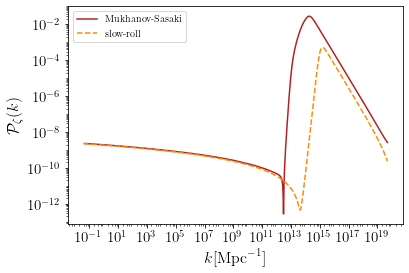

In [4]:
nn_i = round(12.2/dN)
nn_f = -100
k_prime = a[nn_i:nn_f]*H[nn_i:nn_f]
P_zeta_SR = H[nn_i:nn_f]**2 /(8*np.pi*np.pi*eps1[nn_i:nn_f])

fig, ax = plt.subplots()
plt.plot(k, P_zeta, c='firebrick', label='Mukhanov-Sasaki')
plt.plot(k_prime, P_zeta_SR, '--', c='darkorange', label='slow-roll')
plt.xscale('log')
plt.yscale('log')
x_major = tk.LogLocator(base = 10.0, numticks = 12)
ax.xaxis.set_major_locator(x_major)
x_minor = tk.LogLocator(base = 10.0, subs = (0.2,0.4,0.6,0.8), numticks = 24)

y_major = tk.LogLocator(base = 10.0, numticks = 8)
ax.yaxis.set_major_locator(y_major)
y_minor = tk.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 18)
ax.yaxis.set_minor_locator(y_minor)
ax.xaxis.set_minor_locator(x_minor)
ax.yaxis.set_minor_formatter(tk.NullFormatter())
plt.xlabel(r'$k[\rm{Mpc}^{-1}]$', fontsize=16)
plt.ylabel(r'$\mathcal{P}_{\zeta}(k)$', fontsize=16)
plt.legend()
#plt.savefig('P_zeta2.png', dpi=300, bbox_inches='tight')
plt.show()

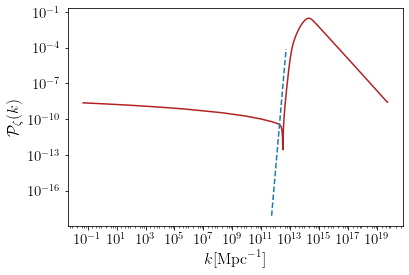

In [35]:
k1 = 0.5*np.logspace(12,13,250)
line = 10**18*(k1/(1.9*10**14))**14

fig, ax = plt.subplots()
plt.plot(k, P_zeta, c='firebrick')
plt.plot(k1,line,'--')
plt.xscale('log')
plt.yscale('log')
x_major = tk.LogLocator(base = 10.0, numticks = 12)
ax.xaxis.set_major_locator(x_major)
x_minor = tk.LogLocator(base = 10.0, subs = (0.2,0.4,0.6,0.8), numticks = 24)

y_major = tk.LogLocator(base = 10.0, numticks = 8)
ax.yaxis.set_major_locator(y_major)
y_minor = tk.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 18)
ax.yaxis.set_minor_locator(y_minor)
ax.xaxis.set_minor_locator(x_minor)
ax.yaxis.set_minor_formatter(tk.NullFormatter())
plt.xlabel(r'$k[\rm{Mpc}^{-1}]$', fontsize=16)
plt.ylabel(r'$\mathcal{P}_{\zeta}(k)$', fontsize=16)
#plt.savefig('P_zeta2.png', dpi=300, bbox_inches='tight')
plt.show()

3049019002821.468